***import Libraries***

In [1]:
import pandas as pd
import numpy as np
#from scipy.stats import gaussian_kde

# 3.7.1 for Kaggle compatibility
import matplotlib.pyplot as plt

# 1.2.2 for Kaggle compatibility
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Hyperparameter tuning for the top 3 models
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


**Read** **Dataset**

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [5]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
df.nunique()

gender                    3
age                     102
hypertension              2
heart_disease             2
smoking_history           6
bmi                    4247
HbA1c_level              18
blood_glucose_level      18
diabetes                  2
dtype: int64

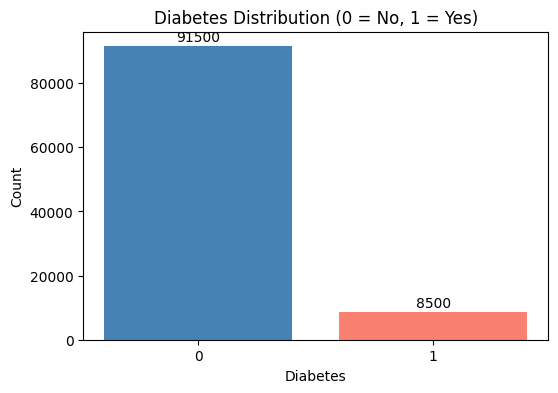

diabetes
0    91500
1     8500
Name: count, dtype: int64


In [7]:
# Count values of diabetes
counts = df['diabetes'].value_counts().sort_index()

# Bar plot
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values, color=['steelblue', 'salmon'])
plt.title("Diabetes Distribution (0 = No, 1 = Yes)")
plt.xlabel("Diabetes")
plt.ylabel("Count")

# Show values on bars
for i, val in enumerate(counts.values):
    plt.text(i, val + 500, str(val), ha='center', va='bottom', fontsize=10)

plt.show()
print(counts)

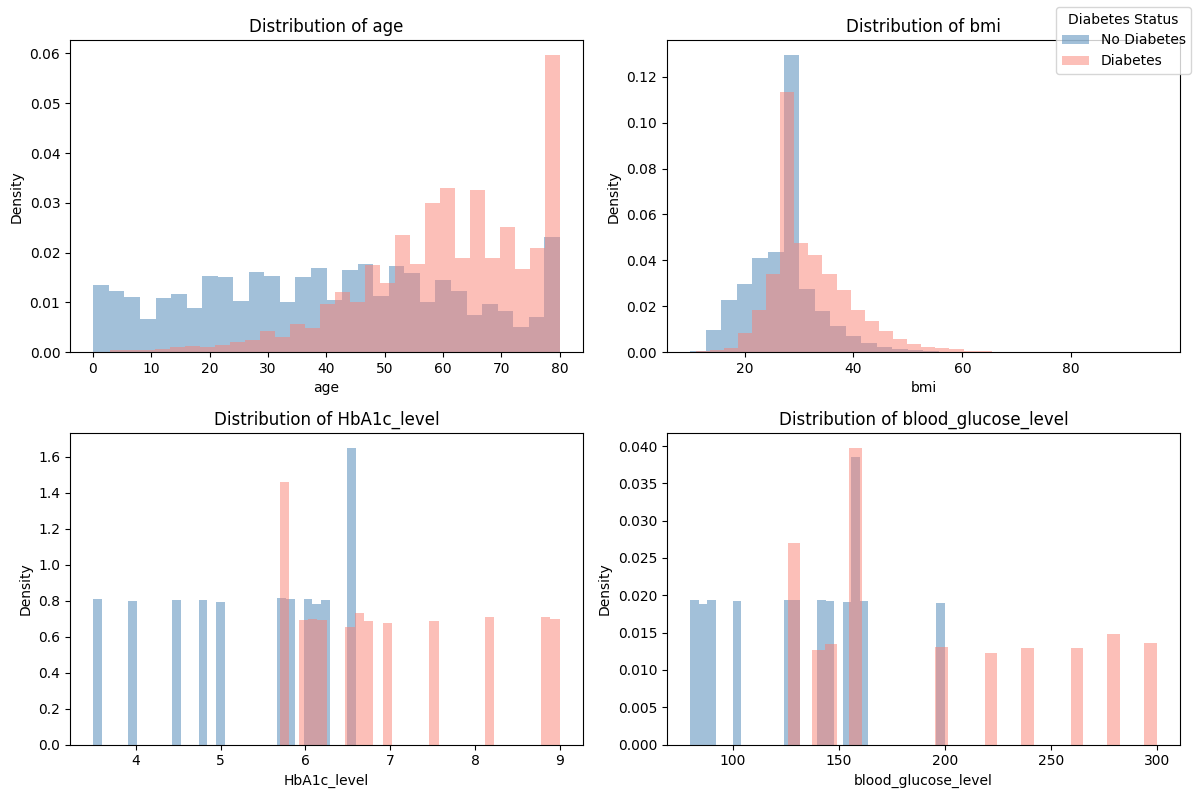

In [8]:

# List of numerical features
num_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

# Colors and labels for diabetes groups
colors = {0: "steelblue", 1: "salmon"}
labels = {0: "No Diabetes", 1: "Diabetes"}

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, num_features):
    for d in [0, 1]:
        data = df[df["diabetes"] == d][col].dropna()

        # Histogram only
        ax.hist(
            data, bins=30, density=True, alpha=0.5,
            color=colors[d], label=labels[d]
        )

    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Density")

# Single legend for the whole figure
fig.legend(
    labels.values(),
    loc="upper right",
    title="Diabetes Status"
)

plt.tight_layout()
plt.show()

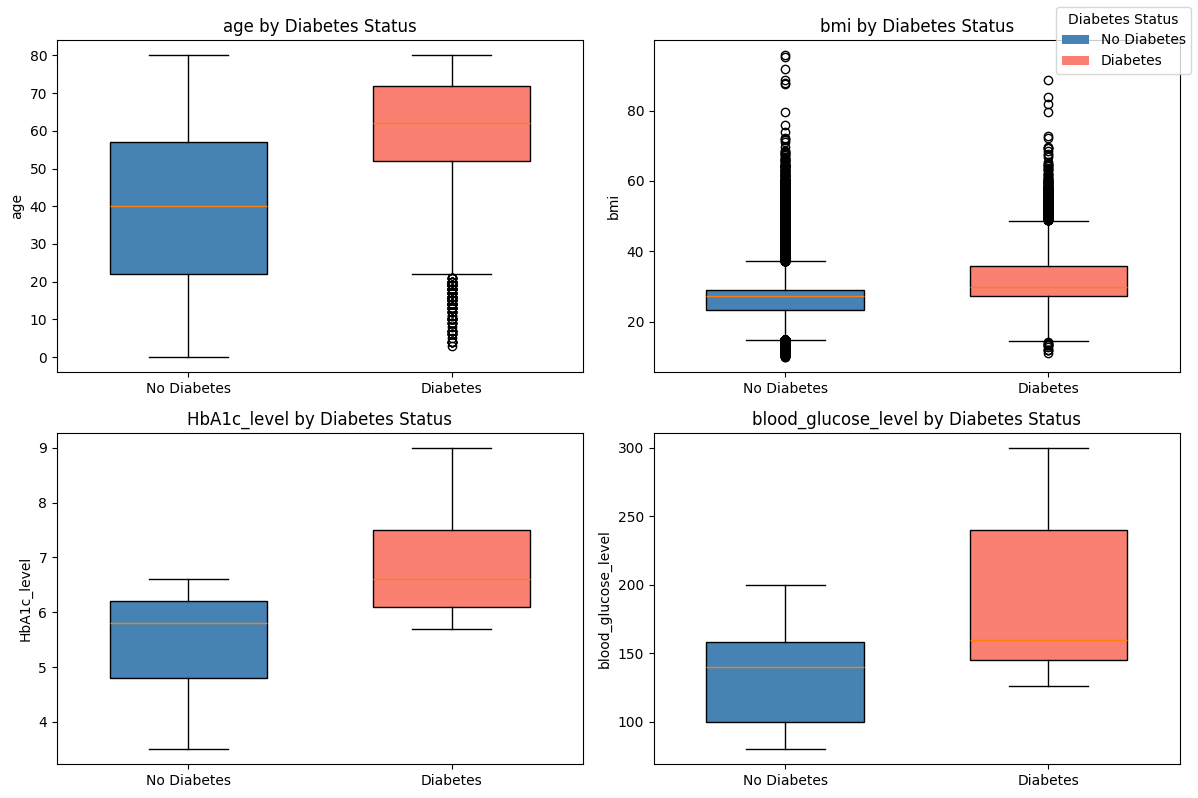

In [9]:
# Numerical features to plot
num_features = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

# Colors for diabetes groups
colors = {0: "steelblue", 1: "salmon"}
labels = {0: "No Diabetes", 1: "Diabetes"}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, num_features):
    # Prepare data for boxplot
    data_to_plot = [df[df["diabetes"] == d][col].dropna() for d in [0, 1]]

    # Boxplot
    bp = ax.boxplot(data_to_plot, patch_artist=True, widths=0.6)

    # Set colors for boxes
    for patch, d in zip(bp['boxes'], [0, 1]):
        patch.set_facecolor(colors[d])

    # Set x-ticks and labels
    ax.set_xticks([1, 2])
    ax.set_xticklabels([labels[0], labels[1]])

    ax.set_title(f"{col} by Diabetes Status")
    ax.set_ylabel(col)

# Single legend for all subplots
from matplotlib.patches import Patch
fig.legend([Patch(facecolor=colors[0]), Patch(facecolor=colors[1])],
           labels.values(), loc="upper right", title="Diabetes Status")

plt.tight_layout()
plt.show()

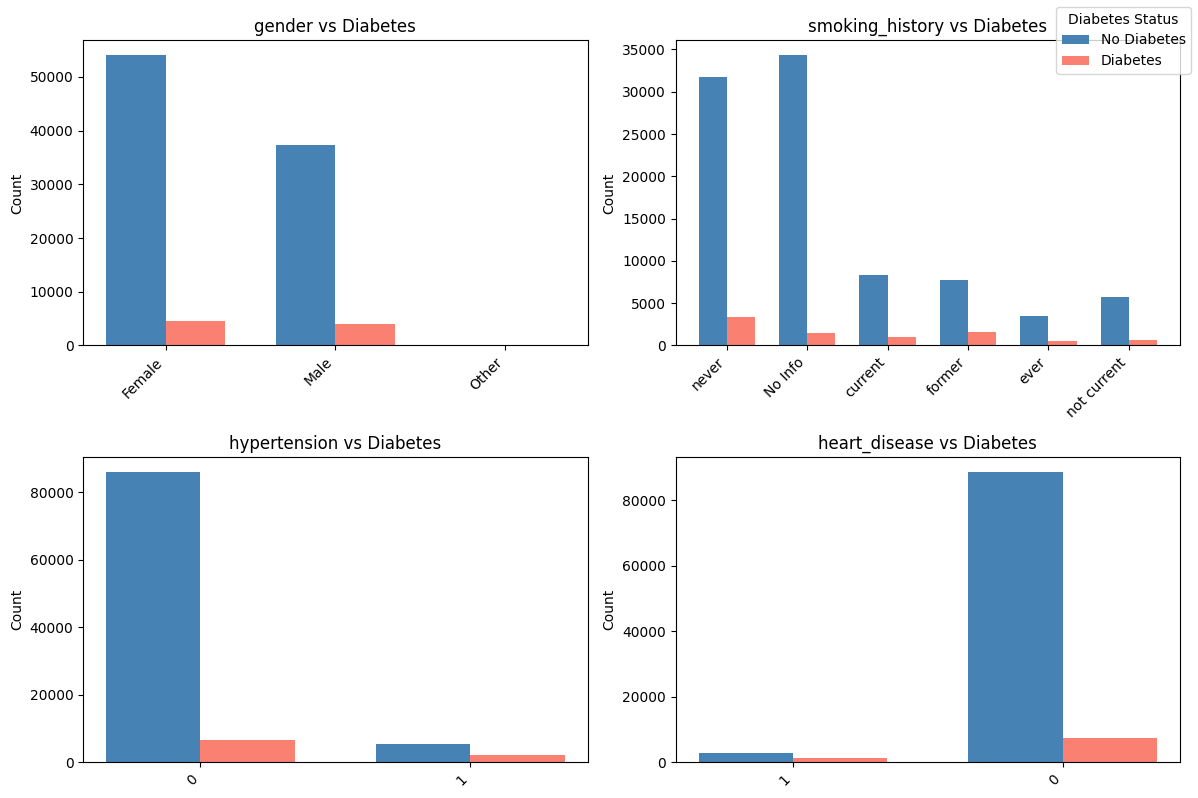

In [10]:
# List of categorical features
cat_features = ["gender", "smoking_history", "hypertension", "heart_disease"]

# Colors for diabetes groups
colors = {0: "steelblue", 1: "salmon"}
labels = {0: "No Diabetes", 1: "Diabetes"}

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, col in zip(axes, cat_features):
    categories = df[col].unique()
    x = np.arange(len(categories))  # x locations for groups
    width = 0.35  # bar width

    counts0 = df[df["diabetes"] == 0][col].value_counts().reindex(categories, fill_value=0)
    counts1 = df[df["diabetes"] == 1][col].value_counts().reindex(categories, fill_value=0)

    ax.bar(x - width/2, counts0.values, width, color=colors[0], label=labels[0])
    ax.bar(x + width/2, counts1.values, width, color=colors[1], label=labels[1])

    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha="right")
    ax.set_ylabel("Count")
    ax.set_title(f"{col} vs Diabetes")

# Single legend for all subplots
fig.legend(labels.values(), loc="upper right", title="Diabetes Status")

plt.tight_layout()
plt.show()

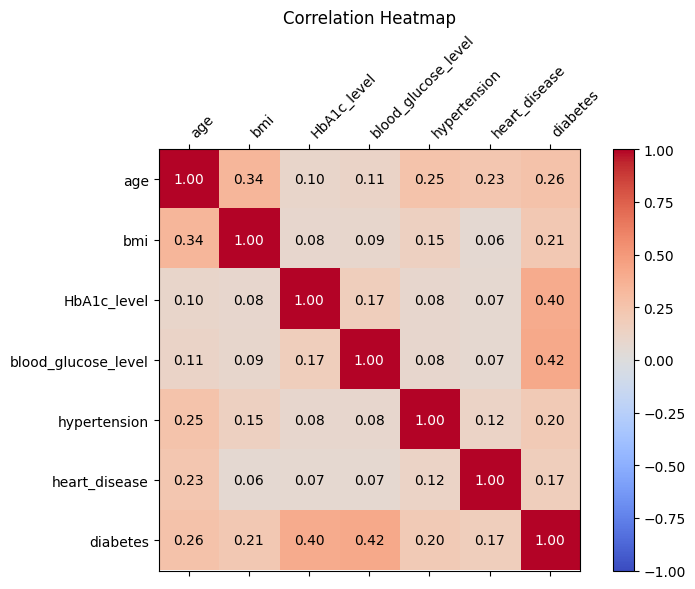

In [11]:
# Select numerical columns only
num_cols = ["age", "bmi", "HbA1c_level", "blood_glucose_level", "hypertension", "heart_disease", "diabetes"]
corr_matrix = df[num_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the correlation matrix as a heatmap
cax = ax.matshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)

# Add colorbar
fig.colorbar(cax)

# Set ticks and labels
ax.set_xticks(np.arange(len(num_cols)))
ax.set_yticks(np.arange(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=45, ha="left")
ax.set_yticklabels(num_cols)

# Annotate each cell with correlation value
for i in range(len(num_cols)):
    for j in range(len(num_cols)):
        c = corr_matrix.iloc[i, j]
        ax.text(j, i, f"{c:.2f}", va="center", ha="center", color="black" if abs(c)<0.5 else "white")

ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()

In [12]:

"""
df = pd.get_dummies(df, columns=['gender'], drop_first=True)
"""

"\ndf = pd.get_dummies(df, columns=['gender'], drop_first=True)\n"

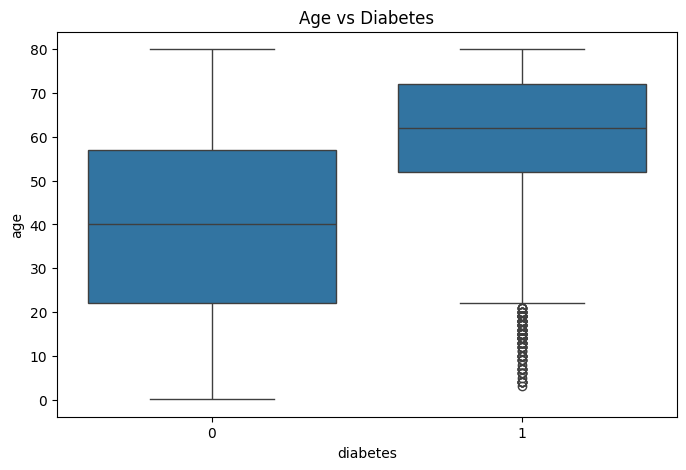

In [14]:
plt.figure(figsize=(8,5))
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

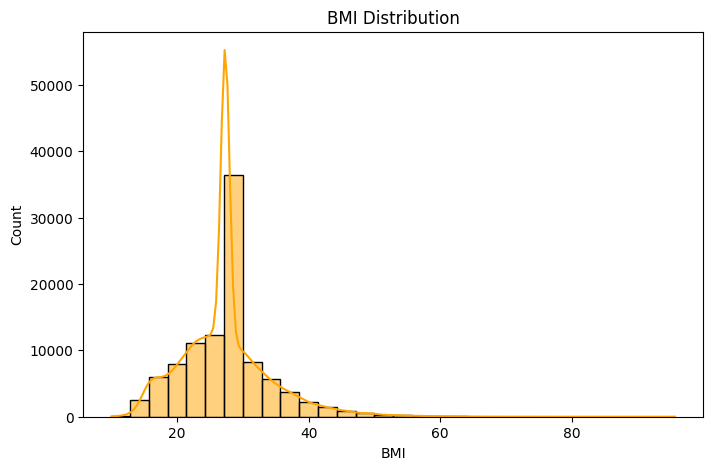

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df['bmi'], bins=30, kde=True, color='orange')
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()



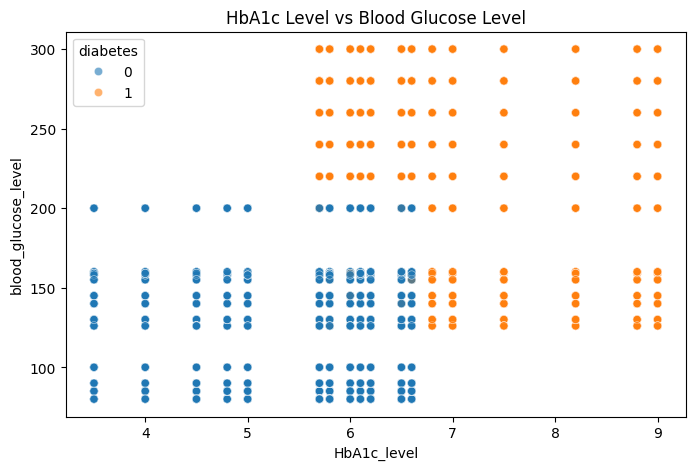

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(x='HbA1c_level', y='blood_glucose_level', hue='diabetes', data=df, alpha=0.6)
plt.title('HbA1c Level vs Blood Glucose Level')
plt.show()


In [17]:
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    cleaned_df = df[(df[column] >= lower) & (df[column] <= upper)]
    return cleaned_df

In [18]:
import numpy as np
from scipy import stats

cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

z = np.abs(stats.zscore(df[cols]))
threshold = 2.5
df = df[(z < threshold).all(axis=1)]

print("Z_score:", df.shape)


Z_score: (94290, 9)


In [19]:
for col in ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']:
    df = remove_outliers_iqr(df, col)


In [20]:
from scipy import stats
df = df[(np.abs(stats.zscore(df[['age','bmi','HbA1c_level','blood_glucose_level']])) < 3).all(axis=1)]
print(df.shape)

(88005, 9)


In [21]:
from dash import Dash, html, dcc, Input, Output
import plotly.express as px
import pandas as pd

# إنشاء التطبيق
app = Dash(__name__)

# تحديد مدى العمر من البيانات نفسها
min_age = int(df['age'].min())
max_age = int(df['age'].max())

# تصميم الواجهة (Layout)
app.layout = html.Div([
    html.H1("📊 Diabetes Dashboard with Age Filter", style={'textAlign': 'center', 'marginBottom': 30}),

    # 🔹 Slider لاختيار مدى العمر
    html.Div([
        html.Label("Select Age Range:", style={'fontWeight': 'bold'}),
        dcc.RangeSlider(
            id='age-slider',
            min=min_age,
            max=max_age,
            step=1,
            marks={i: str(i) for i in range(min_age, max_age+1, 10)},
            value=[min_age, max_age],
            tooltip={"placement": "bottom", "always_visible": True}
        )
    ], style={'margin': '40px'}),

    # 🔹 اختيار المتغير للـ Box Plot
    html.Div([
        html.Label("Select variable for Box Plot:", style={'fontWeight': 'bold'}),
        dcc.Dropdown(
            id='variable-dropdown',
            options=[
                {'label': 'BMI', 'value': 'bmi'},
                {'label': 'HbA1c Level', 'value': 'HbA1c_level'},
                {'label': 'Blood Glucose Level', 'value': 'blood_glucose_level'}
            ],
            value='bmi',
            clearable=False,
            style={'width': '50%', 'margin': 'auto'}
        ),
    ], style={'textAlign': 'center', 'marginBottom': 40}),

    # Box Plot
    dcc.Graph(id='box-plot', style={'height': '500px'}),

    html.Hr(),

    # 🔹 اختيار حالة التدخين للـ Histogram
    html.Div([
        html.Label("Select Smoking History:", style={'fontWeight': 'bold'}),
        dcc.Dropdown(
            id='smoke',
            options=[{'label': s, 'value': s} for s in df['smoking_history'].unique()],
            value=df['smoking_history'].unique()[0],
            clearable=False,
            style={'width': '50%', 'margin': 'auto'}
        ),
    ], style={'textAlign': 'center', 'marginBottom': 40}),

    # Histogram
    dcc.Graph(id='bar-chart', style={'height': '500px'})
])


In [22]:
# 🔹 Callback 1 → Box Plot
@app.callback(
    Output('box-plot', 'figure'),
    [Input('variable-dropdown', 'value'),
     Input('age-slider', 'value')]
)
def update_box_plot(selected_var, age_range):
    filtered_df = df[(df['age'] >= age_range[0]) & (df['age'] <= age_range[1])]
    fig = px.box(
        filtered_df,
        x='diabetes',
        y=selected_var,
        color='diabetes',
        title=f"Distribution of {selected_var.capitalize()} by Diabetes Status (Age {age_range[0]}–{age_range[1]})",
        labels={'diabetes': 'Diabetes', selected_var: selected_var.capitalize()},
        template='plotly_white'
    )
    fig.update_layout(title_x=0.5)
    return fig


# 🔹 Callback 2 → Histogram
@app.callback(
    Output('bar-chart', 'figure'),
    [Input('smoke', 'value'),
     Input('age-slider', 'value')]
)
def update_chart(smoke_value, age_range):
    filtered = df[(df['smoking_history'] == smoke_value) &
                  (df['age'] >= age_range[0]) &
                  (df['age'] <= age_range[1])]

    fig = px.histogram(
        filtered,
        x='age',
        color='diabetes',
        barmode='group',
        title=f"Diabetes by Age ({smoke_value}) - Age {age_range[0]}–{age_range[1]}",
        labels={'age': 'Age', 'diabetes': 'Diabetes Status'},
        template='plotly_white'
    )
    fig.update_layout(title_x=0.5)
    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8052)


In [23]:
# Define features and target
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [24]:
#Stratified train/validation/test split (60/20/20)
# First split off test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Split remaining 80% into train (60%) and validation (20%)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

In [25]:
# Identify categorical and numerical columns
categorical_features = ['gender', 'smoking_history']
numerical_features = ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [26]:
# Define models with class imbalance handling
models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=200, random_state=42),
    'XGBoost': XGBClassifier(
        scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    'LightGBM': LGBMClassifier(class_weight='balanced', random_state=42),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(class_weight='balanced', probability=True, random_state=42)
}

In [27]:
# Train, validate, and evaluate models
results = {}

for name, model in models.items():
    print(f"\n========== {name} ==========")

    # Build pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train on training set
    pipeline.fit(X_train, y_train)

    # Predict on validation set
    y_pred = pipeline.predict(X_valid)
    y_proba = pipeline.predict_proba(X_valid)[:,1] if hasattr(model, "predict_proba") else None

    # Metrics
    print("Classification Report (Validation Set):")
    print(classification_report(y_valid, y_pred, digits=4))

    if y_proba is not None:
        auc = roc_auc_score(y_valid, y_proba)
        print(f"ROC AUC Score: {auc:.4f}")

    results[name] = pipeline


========== Logistic Regression ==========
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9922    0.8350    0.9068     16828
           1     0.1925    0.8564    0.3143       773

    accuracy                         0.8359     17601
   macro avg     0.5923    0.8457    0.6106     17601
weighted avg     0.9570    0.8359    0.8808     17601

ROC AUC Score: 0.9295

========== Decision Tree ==========
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9769    0.9758    0.9763     16828
           1     0.4855    0.4981    0.4917       773

    accuracy                         0.9548     17601
   macro avg     0.7312    0.7369    0.7340     17601
weighted avg     0.9553    0.9548    0.9551     17601

ROC AUC Score: 0.7371

========== Random Forest ==========
Classification Report (Validation Set):
              precision    recall  f1-score   support

          

/home/maher/.local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning:

[12:48:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9891    0.9052    0.9453     16828
           1     0.2750    0.7827    0.4070       773

    accuracy                         0.8998     17601
   macro avg     0.6320    0.8439    0.6761     17601
weighted avg     0.9577    0.8998    0.9217     17601

ROC AUC Score: 0.9491

========== LightGBM ==========
[LightGBM] [Info] Number of positive: 2319, number of negative: 50484
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 52803, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9932    0.8826    0.9346     16828
           1     0.2535    0.8680    0.3924       773

    accuracy                         0.8819     17601
   macro avg     0.6233    0.8753    0.6635     17601
weighted avg     0.9607    0.8819    0.9108     17601

ROC AUC Score: 0.9557

========== KNN ==========
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9673    0.9952    0.9810     16828
           1     0.7188    0.2678    0.3902       773

    accuracy                         0.9632     17601
   macro avg     0.8430    0.6315    0.6856     17601
weighted avg     0.9564    0.9632    0.9551     17601

ROC AUC Score: 0.8128

========== SVM ==========
Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.9953    0.8363    0.9089     16828
           1     0.

In [28]:
# Define hyperparameter grids for top 3 models
param_grids = {
    'LightGBM': {
        'classifier__num_leaves': [31, 50, 100],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__min_child_samples': [20, 50, 100]
    },
    'XGBoost': {
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__subsample': [0.7, 0.8, 1.0],
        'classifier__colsample_bytree': [0.7, 0.8, 1.0]
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['sqrt', 'log2']
    }
}

In [29]:
# Use StratifiedKFold to maintain class balance in folds
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
# 'LightGBM', 'XGBoost', 'Random Forest'
for name in ['LightGBM', 'XGBoost', 'Random Forest']:
    print(f"\n===== Hyperparameter Tuning: {name} =====")

    # Define estimator
    if name == 'LightGBM':
        estimator = LGBMClassifier(
            class_weight='balanced',
            force_row_wise=True,
            random_state=42,
            n_jobs=1 # adjusted to 1 from -1 to prevent CPU thrashing
        )
    elif name == 'XGBoost':
        estimator = XGBClassifier(
            scale_pos_weight=(len(y_train)-sum(y_train))/sum(y_train),
            eval_metric='logloss',
            random_state=42,
            n_jobs=1 # adjusted to 1 from -1 to prevent CPU thrashing
        )
    else:  # Random Forest
        estimator = RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_jobs=-1
        )

    # Pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', estimator)
    ])

    # RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=param_grids[name],
        n_iter=10,  # fewer iterations for speed
        scoring='roc_auc',
        cv=cv_strategy,
        verbose=0, # verbose off
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)

    print(f"Best Parameters for {name}: {search.best_params_}")
    print(f"Best ROC AUC (CV) for {name}: {search.best_score_:.4f}")

    best_models[name] = search.best_estimator_



===== Hyperparameter Tuning: LightGBM =====
[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:Boo

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 1855, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42242, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1856, number of negative: 40387
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 1855, number of negative: 40388
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 42243, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 2319, number of negative: 50484
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 52803, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best Parameters for LightGBM: {'classifier__num_leaves': 31, 'classifier__n_estimators': 300, 'classifier__min_child_samples': 50, 'classifier__learning_rate': 0.01}
Best ROC AUC (CV) for LightGBM: 0.9600

===== Hyperparameter Tuning: XGBoost =====
Best Parameters for XGBoost: {'classifier__subsample': 1.0, 'classifier__n_estimators': 300, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__colsample_bytree': 0.8}
Best ROC AUC (CV) for XGBoost: 0.9609

===== Hyperparameter Tuning: Random Forest =====
Best Parameters for Random Forest: {'classifier__n_estimators': 500, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 4, 

In [30]:
# Evaluate tuned models on validation set
for name, model in best_models.items():
    y_pred = model.predict(X_valid)
    print(X_valid.head(10))
    y_proba = model.predict_proba(X_valid)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n===== {name} Validation Performance =====")
    print(classification_report(y_valid, y_pred, digits=4))
    if y_proba is not None:
        auc = roc_auc_score(y_valid, y_proba)
        print(f"ROC AUC Score: {auc:.4f}")

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



       gender   age  hypertension  heart_disease smoking_history    bmi  \
79546  Female  53.0             0              0         No Info  31.79   
72470  Female  24.0             0              0         No Info  31.76   
35003  Female  58.0             0              0           never  30.81   
28459  Female  79.0             1              0           never  29.60   
1597     Male  23.0             0              0           never  25.04   
76030    Male  80.0             0              0         No Info  27.32   
88022  Female  39.0             1              0         No Info  27.32   
5961   Female  10.0             0              0         No Info  27.57   
1235   Female  63.0             0              0           never  19.46   
81447  Female  80.0             0              0         No Info  22.91   

       HbA1c_level  blood_glucose_level  
79546          4.5                  158  
72470          5.7                  200  
35003          3.5                  200  
28459 

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




===== LightGBM Validation Performance =====
              precision    recall  f1-score   support

           0     0.9946    0.8612    0.9231     16828
           1     0.2293    0.8991    0.3654       773

    accuracy                         0.8628     17601
   macro avg     0.6120    0.8801    0.6443     17601
weighted avg     0.9610    0.8628    0.8986     17601

ROC AUC Score: 0.9578
       gender   age  hypertension  heart_disease smoking_history    bmi  \
79546  Female  53.0             0              0         No Info  31.79   
72470  Female  24.0             0              0         No Info  31.76   
35003  Female  58.0             0              0           never  30.81   
28459  Female  79.0             1              0           never  29.60   
1597     Male  23.0             0              0           never  25.04   
76030    Male  80.0             0              0         No Info  27.32   
88022  Female  39.0             1              0         No Info  27.32   
5961  

In [31]:
# Evaluate tuned models on test set
for name, model in best_models.items():
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"\n===== {name} Final Test Performance =====")
    print(classification_report(y_test, y_pred_test, digits=4))
    if y_proba_test is not None:
        auc_test = roc_auc_score(y_test, y_proba_test)
        print(f"ROC AUC Score: {auc_test:.4f}")


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names




===== LightGBM Final Test Performance =====
              precision    recall  f1-score   support

           0     0.9960    0.8638    0.9252     16828
           1     0.2375    0.9237    0.3779       773

    accuracy                         0.8664     17601
   macro avg     0.6167    0.8937    0.6515     17601
weighted avg     0.9626    0.8664    0.9011     17601

ROC AUC Score: 0.9620

===== XGBoost Final Test Performance =====
              precision    recall  f1-score   support

           0     0.9964    0.8621    0.9244     16828
           1     0.2370    0.9327    0.3780       773

    accuracy                         0.8652     17601
   macro avg     0.6167    0.8974    0.6512     17601
weighted avg     0.9631    0.8652    0.9004     17601

ROC AUC Score: 0.9641

===== Random Forest Final Test Performance =====
              precision    recall  f1-score   support

           0     0.9838    0.9663    0.9750     16828
           1     0.4716    0.6546    0.5482       773


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



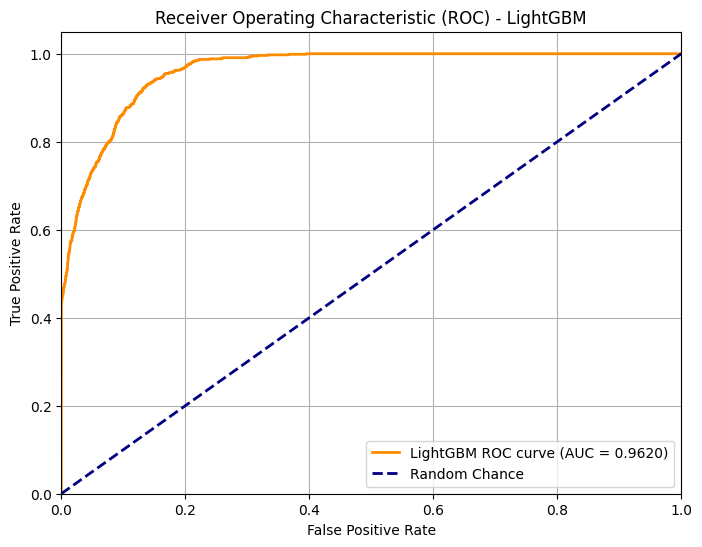

In [32]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc as sklearn_auc  # explicitly rename to avoid conflicts

# Get predicted probabilities for the positive class
y_proba_test = best_models['LightGBM'].predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_proba_test)
roc_auc_value = sklearn_auc(fpr, tpr)  # use the renamed function

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'LightGBM ROC curve (AUC = {roc_auc_value:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - LightGBM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



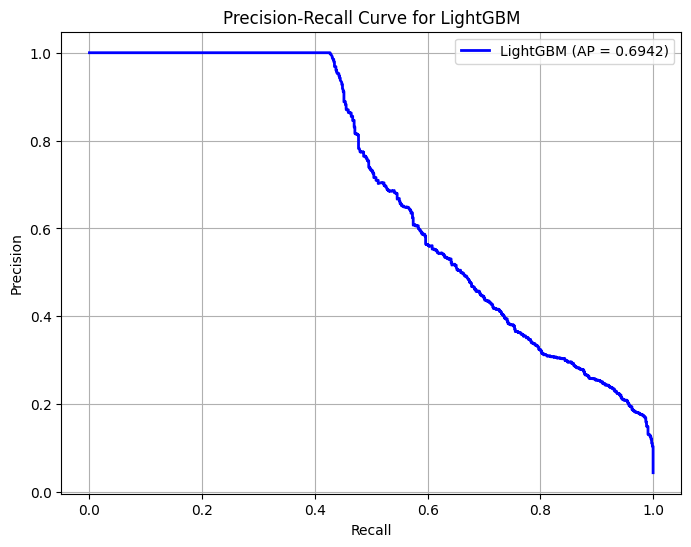

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get the predicted probabilities for the positive class
y_proba = best_models['LightGBM'].predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# Plot Precision-Recall curve
plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='b', lw=2, label=f'LightGBM (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for LightGBM')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



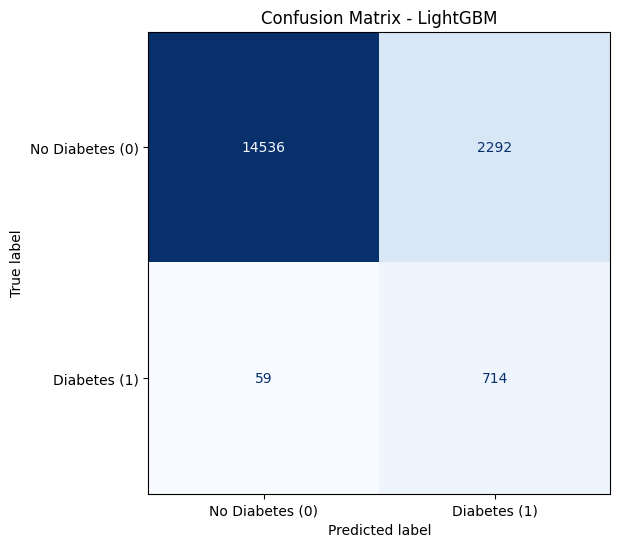

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Get predictions
y_pred = best_models['LightGBM'].predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8,6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes (0)', 'Diabetes (1)'])
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
ax.set_title("Confusion Matrix - LightGBM")
plt.show()


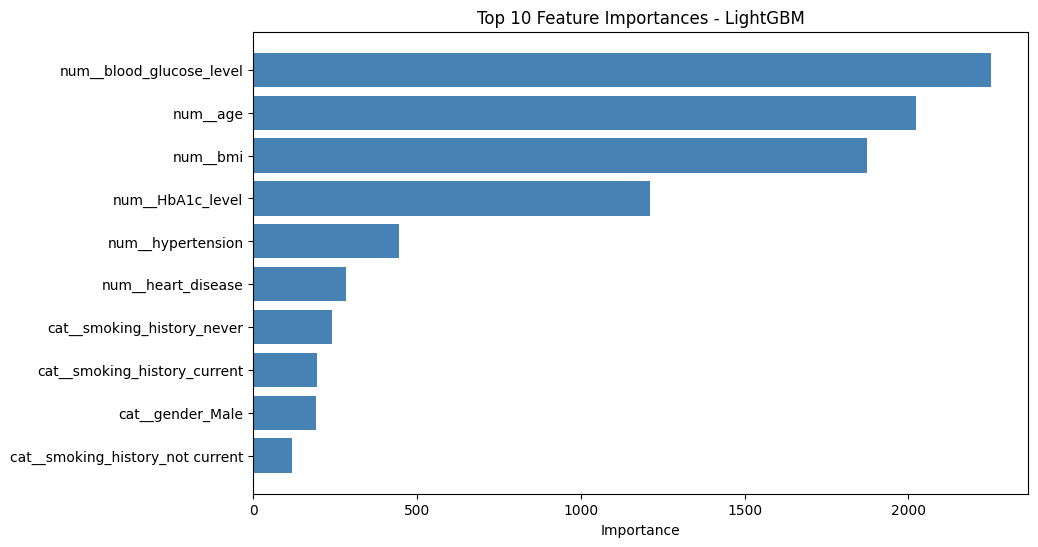

In [35]:
# Extract trained LightGBM model from pipeline
lgbm_model = best_models['LightGBM'].named_steps['classifier']

# Get feature names from preprocessing pipeline
feature_names = best_models['LightGBM'].named_steps['preprocessor'].get_feature_names_out()

# Get feature importance
importances = lgbm_model.feature_importances_

# Create a DataFrame for easy sorting
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(10,6))
plt.barh(feat_imp['Feature'][:10][::-1], feat_imp['Importance'][:10][::-1], color="steelblue")
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances - LightGBM")
plt.show()

In [36]:
import joblib

# Save the pipeline (includes preprocessing + model)
joblib.dump(best_models['LightGBM'], 'lightgbm_pipeline.pkl')

print("Model saved as 'lightgbm_pipeline.pkl'")


Model saved as 'lightgbm_pipeline.pkl'


In [37]:
import joblib

# Save the tuned XGBoost pipeline
joblib.dump(best_models['XGBoost'], r'C:\Users\user\Desktop\Asmaa\Light\xgboost_pipeline.pkl')

print("XGBoost pipeline saved successfully!")


XGBoost pipeline saved successfully!


**New** **CLEAN**,**PRE**,**MODEL**

**Import** **Libraries**

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import joblib
import os

print("Python", os.sys.version.splitlines()[0])


Python 3.10.12 (main, Nov  4 2025, 08:48:33) [GCC 11.4.0]


**Load Dataset And Information about IT**

In [39]:
DATA_PATH = "diabetes_prediction_dataset.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all'))


Shape: (100000, 9)


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


None

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000,100000.000000,100000.00000,100000.000000,100000,100000.000000,100000.000000,100000.000000,100000.000000
unique,3,NaN,NaN,NaN,6,NaN,NaN,NaN,NaN
top,Female,NaN,NaN,NaN,No Info,NaN,NaN,NaN,NaN
freq,58552,NaN,NaN,NaN,35816,NaN,NaN,NaN,NaN
mean,NaN,41.885856,0.07485,0.039420,NaN,27.320767,5.527507,138.058060,0.085000
std,NaN,22.516840,0.26315,0.194593,NaN,6.636783,1.070672,40.708136,0.278883
min,NaN,0.080000,0.00000,0.000000,NaN,10.010000,3.500000,80.000000,0.000000
25%,NaN,24.000000,0.00000,0.000000,NaN,23.630000,4.800000,100.000000,0.000000
50%,NaN,43.000000,0.00000,0.000000,NaN,27.320000,5.800000,140.000000,0.000000
75%,NaN,60.000000,0.00000,0.000000,NaN,29.580000,6.200000,159.000000,0.000000


**Clean Duplicates and Missing values**

In [40]:
# duplicates
print("Duplicates:", df.duplicated().sum())
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print("Dropped duplicates, new shape:", df.shape)

# missing
print("Missing per column:")
print(df.isnull().sum())


Duplicates: 3854
Dropped duplicates, new shape: (96146, 9)
Missing per column:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


In [41]:
# نحاول نلقى اسم العمود الهدف common names
target_candidates = ['diabetes','Outcome','target','class','Label']
target = None
for cand in target_candidates:
    if cand in df.columns:
        target = cand
        break
if target is None:
    target = df.columns[-1]   # افتراض أن آخر عمود هو الهدف

print("Chosen target:", target)

# فصل X و y
y = df[target].copy()
X = df.drop(columns=[target]).copy()

# إذا target نصيّ، نعاملها
if y.dtype == 'object' or y.dtype.name == 'category':
    y, uniques = pd.factorize(y)
    print("Encoded target classes:", list(uniques))

# أعمدة عددية وفئوية
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)
print("Target distribution:\n", pd.Series(y).value_counts(normalize=False))


Chosen target: diabetes
Numeric columns: ['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level']
Categorical columns: ['gender', 'smoking_history']
Target distribution:
 diabetes
0    87664
1     8482
Name: count, dtype: int64


**Z-Score Method**

In [42]:
def compute_z_scores(arr):
    # arr numpy array shape (n_samples, n_features)
    mean = np.mean(arr, axis=0)
    std = np.std(arr, axis=0, ddof=0)
    z = (arr - mean) / std
    return z, mean, std

# مثال سريع (لو في أعمدة عددية)
if len(num_cols) > 0:
    sample = X[num_cols].iloc[:200].values
    z, m, s = compute_z_scores(sample)
    print("example z shape:", z.shape)


example z shape: (200, 6)


**Scaling & Defining Models**

In [43]:
# preprocessors
# --- Numeric Pipeline ---
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# --- Categorical Pipeline ---
categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# --- Full Preprocessor ---
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

# --- Define Models ---
models = {
    'logreg': LogisticRegression(max_iter=2000),
    'rf': RandomForestClassifier(n_estimators=300, random_state=42),
    'xgb': XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    ),
    'lgbm': LGBMClassifier(random_state=42)
}

print("Preprocessor and models have been defined successfully.")


Preprocessor and models have been defined successfully.


**Split Data**

In [44]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (76916, 8) Test: (19230, 8)


**Evaluation the Data**

In [45]:
def train_and_eval(model, X_train, X_test, y_train, y_test):
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    probas = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, 'predict_proba') else None
    roc = roc_auc_score(y_test, probas) if probas is not None else None
    print(f"Model: {model.__class__.__name__}  - ROC AUC: {roc}")
    print(classification_report(y_test, preds))
    return pipe, preds, probas

results = {}
for name, model in models.items():
    try:
        pipe, preds, probas = train_and_eval(model, X_train, X_test, y_train, y_test)
        results[name] = {'pipe': pipe, 'preds': preds, 'probas': probas}
    except Exception as e:
        print("Error for", name, ":", e)


Model: LogisticRegression  - ROC AUC: 0.959895605788
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     17534
           1       0.87      0.64      0.74      1696

    accuracy                           0.96     19230
   macro avg       0.92      0.81      0.86     19230
weighted avg       0.96      0.96      0.96     19230

Model: RandomForestClassifier  - ROC AUC: 0.9598137062817039
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.95      0.69      0.80      1696

    accuracy                           0.97     19230
   macro avg       0.96      0.84      0.89     19230
weighted avg       0.97      0.97      0.97     19230



/home/maher/.local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning:

[13:09:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Model: XGBClassifier  - ROC AUC: 0.9756487933954731
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.95      0.70      0.80      1696

    accuracy                           0.97     19230
   macro avg       0.96      0.85      0.89     19230
weighted avg       0.97      0.97      0.97     19230

[LightGBM] [Info] Number of positive: 6786, number of negative: 70130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 76916, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088226 -> initscore=-2.335489
[LightGBM] [Info] Start training from score -2.335489


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



Model: LGBMClassifier  - ROC AUC: 0.977034578102705
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.97      0.69      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.97      0.85      0.90     19230
weighted avg       0.97      0.97      0.97     19230



**Hyper parameters**

In [46]:
param_grids = {
    'rf': {
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [None, 6, 10, 20],
        'clf__min_samples_split': [2, 5, 10]
    },
    'xgb': {
        'clf__n_estimators': [100, 200, 400],
        'clf__max_depth': [3, 6, 10],
        'clf__learning_rate': [0.01, 0.05, 0.1]
    },
    'lgbm': {
        'clf__n_estimators': [100, 200, 400],
        'clf__num_leaves': [31, 50, 100],
        'clf__learning_rate': [0.01, 0.05, 0.1]
    }
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
best_models = {}

for key in ['rf','xgb','lgbm']:
    base = models[key]
    pipe = Pipeline(steps=[('pre', preprocessor), ('clf', base)])
    params = param_grids[key]
    rs = RandomizedSearchCV(pipe, params, n_iter=8, cv=cv, scoring='roc_auc', random_state=42, n_jobs=-1)
    print("\\nRunning RandomizedSearch for", key)
    rs.fit(X_train, y_train)
    print("Best score (cv):", rs.best_score_)
    print("Best params:", rs.best_params_)
    best_models[key] = rs.best_estimator_


\nRunning RandomizedSearch for rf
Best score (cv): 0.9711311926591828
Best params: {'clf__n_estimators': 400, 'clf__min_samples_split': 10, 'clf__max_depth': 20}
\nRunning RandomizedSearch for xgb


/home/maher/.local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [13:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/maher/.local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [13:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/maher/.local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [13:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/maher/.local/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [13:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/maher/.local/lib/python3.10/site-packages/xgboost/training.py:

Best score (cv): 0.9793838340759716
Best params: {'clf__n_estimators': 400, 'clf__max_depth': 3, 'clf__learning_rate': 0.05}
\nRunning RandomizedSearch for lgbm
[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `for

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028994 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [bin

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [bin

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597
[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[Light

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[Light

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597
[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[Light

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[Light

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in th

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5090, number of negative: 52597
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088235 -> initscore=-2.335381
[LightGBM] [Info] Start training from score -2.335381
[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [bin

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 5089, number of negative: 52598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 57687, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088217 -> initscore=-2.335597
[LightGBM] [Info] Start training from score -2.335597


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 6786, number of negative: 70130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 418
[LightGBM] [Info] Number of data points in the train set: 76916, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.088226 -> initscore=-2.335489
[LightGBM] [Info] Start training from score -2.335489
Best score (cv): 0.9787587718305868
Best params: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.05}


**Evaluate Best Models on Testset**

\nModel: rf ROC AUC: 0.9692123093461544
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.99      0.68      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



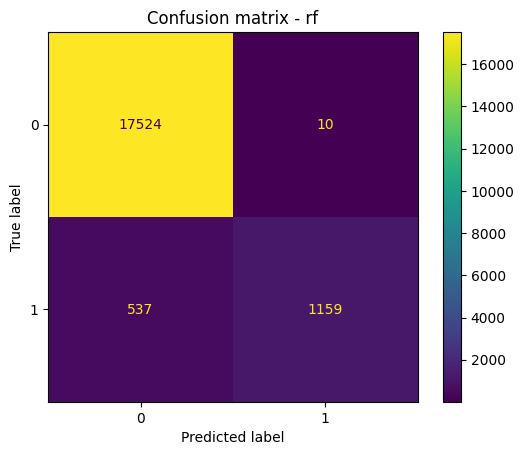

\nModel: xgb ROC AUC: 0.977942921138661
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.99      0.69      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



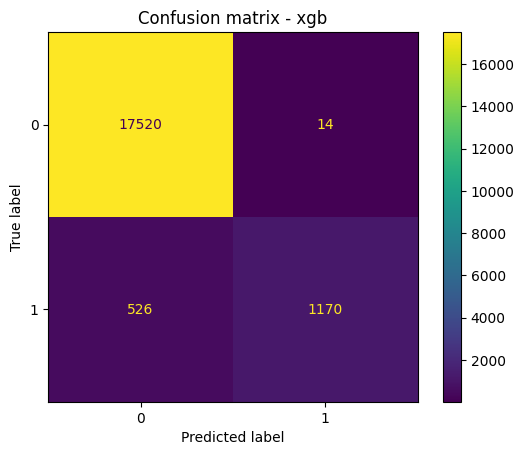

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



\nModel: lgbm ROC AUC: 0.977197704567514
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17534
           1       0.99      0.69      0.81      1696

    accuracy                           0.97     19230
   macro avg       0.98      0.84      0.90     19230
weighted avg       0.97      0.97      0.97     19230



/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names



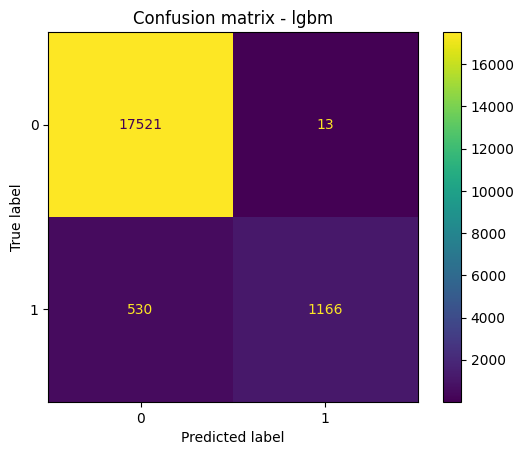

In [47]:
for name, est in best_models.items():
    y_pred = est.predict(X_test)
    y_proba = est.predict_proba(X_test)[:,1] if hasattr(est, 'predict_proba') else None
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print("\\nModel:", name, "ROC AUC:", roc)
    print(classification_report(y_test, y_pred))
    disp = ConfusionMatrixDisplay.from_estimator(est, X_test, y_test)
    plt.title(f"Confusion matrix - {name}")
    plt.show()


**Find Best Model**

In [48]:
# نختار الأفضل حسب roc (إن وُجد)
best_key = None
best_score = -np.inf

for k, est in best_models.items():
    try:
        proba = est.predict_proba(X_test)[:,1]
        sc = roc_auc_score(y_test, proba)
        if sc > best_score:
            best_score = sc
            best_key = k
    except Exception:
        continue

if best_key is None and len(best_models) > 0:
    best_key = list(best_models.keys())[0]

if best_key:
    joblib.dump(best_models[best_key], f"best_model_{best_key}.joblib")
    print("Saved best model:", best_key, "score:", best_score)
else:
    print("No model saved.")


Saved best model: xgb score: 0.977942921138661


/home/maher/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but LGBMClassifier was fitted with feature names

